<a href="https://colab.research.google.com/github/alibouch/TensorFlow_FSA_21-22/blob/main/Atelier_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atelier 9 : LES AUTOENCODEURS

In [4]:

import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

## PCA AVEC UN AUTOENCODEUR LINÉAIRE

Si l’autoencodeur utilise uniquement des activations linéaires et si la fonction de coût est l’erreur quadratique moyenne (MSE, Mean Squared Error), alors on peut montrer qu’il réalise une **An**alyse en **C**omposantes **P**rincipales (**PCA**).

Commençons par construire le dataset 3D :

In [5]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

Le code suivant construit un autoencodeur linéaire simple pour effectuer une **PCA** sur un jeu de données à trois dimensions, en le projetant sur deux dimensions:

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

Ce code n’est pas très différent de tous les réseaux de neurones que nous avons construits jusqu'à présent. Quelques remarques cependant:
* Nous avons organisé l’autoencodeur en deux sous-composants: **l’encodeur** et **le décodeur**. Tous deux sont des modèles `Sequential` normaux, chacun avec une seule couche `Dense`. L’autoencodeur est un modèle `Sequential` qui contient l’encodeur suivi du décodeur (rappelez-vous qu’un modèle peut être
utilisé en tant que couche dans un autre modèle).
* Le nombre de sorties de l’autoencodeur est égal au nombre d’entrées (c’est-à-dire trois).
*  Pour effectuer une PCA simple, nous n’utilisons pas de fonction d’activation (autrement dit, tous les neurones sont linéaires) et la fonction de coût est la MSE.

Entraînons à présent le modèle sur notre jeu de données à trois dimensions et utilisons-le pour encoder ce même jeu de données (c’est-à-dire en faire une projection sur deux dimensions):

In [7]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 2s 10ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 8ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 11ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 9ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 10ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 11ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 10ms/step - l

In [8]:
codings = encoder.predict(X_train)

Saving figure linear_autoencoder_pca_plot


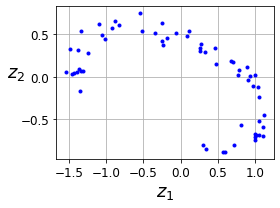

In [9]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
save_fig("linear_autoencoder_pca_plot")
plt.show()

Notez que le même jeu de données, `X_train`, est utilisé pour les entrées et pour les cibles. La figure suivante montre le jeu de données original à trois dimensions (à gauche) et la sortie de la couche cachée de l’autoencodeur (c’est-à-dire la couche de codage, à droite). Vous le constatez, l’autoencodeur a trouvé le meilleur plan à deux dimensions sur lequel projeter les données, tout en conservant autant de différence
que possible dans les données (à l’instar de la PCA).

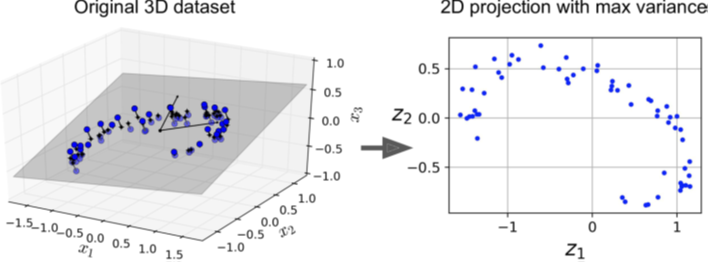

## AUTOENCODEURS EMPILÉS

À l’instar des autres réseaux de neurones, les autoencodeurs
peuvent comprendre plusieurs couches cachées. Dans ce cas, il s’agit d’autoencodeurs
empilés (ou autoencodeurs profonds).

L’architecture d’un autoencodeur empilé est le plus souvent symétrique par rapport
à la couche cachée centrale (la couche de codage). Plus simplement, il ressemble à
un sandwich. Par exemple, un autoencodeur pour la classification **MNIST** pourrait
avoir 784 entrées, une couche cachée de 100 neurones, une couche cachée centrale
de 30 neurones, une autre couche cachée de 100 neurones, et une couche de sortie
de 784 neurones. Un tel autoencodeur est représenté à la figure suivante :

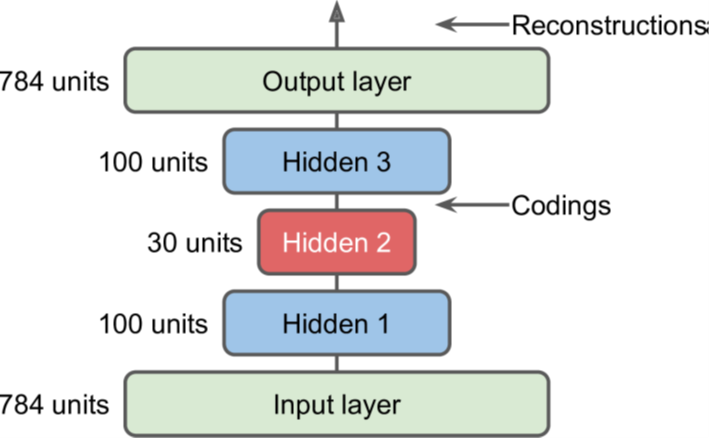

Construisons un autoencodeur empilé pour le jeu de données **Fashion MNIST** :

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


### Implémenter un autoencodeur empilé avec Keras

In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

1. Complétez le code suivant sachant que :
*  L’encodeur prend en entrée des images en niveaux de gris de `28×28` pixels, les aplatit afin de représenter chacune sous forme d’un vecteur de taille `784`, puis passe les vecteurs obtenus au travers de deux couches Dense de taille décroissante (`100` puis `30` unités), toutes deux utilisant la fonction d’activation `SELU`. Pour chaque image d’entrée, l’encodeur produit un vecteur de taille `30`.
* Le décodeur prend les codages de taille `30` (générés par l’encodeur) et les passe
au travers de deux couches Dense de taille croissante (`100` puis `784` unités). Il
remet les vecteurs finaux sous forme de tableaux `28×28` afin que ses sorties aient
la même forme que les entrées de l’encodeur.
* Pour la compilation de l’autoencodeur empilé, nous remplaçons l’erreur
quadratique moyenne par la perte d’entropie croisée binaire (binary cross-entropy). 
* Enfin, nous entraînons le modèle en utilisant `X_train` à la fois pour les entrées
et les cibles (de façon similaire, nous utilisons `X_valid` pour les entrées et les
cibles de validation).

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
                                              ,
                                              ,
                                              ,
])
stacked_decoder = keras.models.Sequential([
                                                      ,
                                                      ,
    
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss=                  ,
                   optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = stacked_ae.fit(     ,       , epochs=20,
                         validation_data=(       ,       ))

Epoch 1/20
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3170 - val_rounded_accuracy: 0.8996
Epoch 2/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9199
Epoch 3/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2985 - val_rounded_accuracy: 0.9200
Epoch 4/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9285
Epoch 5/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2920 - val_rounded_accuracy: 0.9284
Epoch 6/20
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9306
Epoch 7/20
1719/1719 [=================

Pour s’assurer que l’entraînement d’un autoencodeur est correct, une solution consiste
à comparer les entrées et les sorties: les différences doivent concerner des détails peu
importants. Affichons quelques images du jeu de validation et leur reconstruction:



In [13]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

Saving figure reconstruction_plot


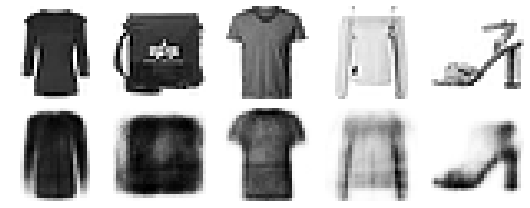

In [14]:
show_reconstructions(stacked_ae)
save_fig("reconstruction_plot")

Les reconstructions sont reconnaissables, mais la perte est un peu trop importante.
Nous pourrions entraîner le modèle plus longtemps, rendre l’encodeur et le décodeur
plus profonds, ou rendre les codages plus grands. Mais si le réseau devient trop puissant, il réalisera des reconstructions parfaites sans découvrir de motifs utiles dans les
données. Pour le moment, conservons ce modèle.

### Visualiser le jeu de données Fashion MNIST

À présent que nous disposons d’un autoencodeur empilé entraîné, nous pouvons
nous en servir pour réduire la dimensionnalité du jeu de données. Dans le cadre de la
visualisation, les résultats ne sont pas aussi bons que ceux obtenus avec d’autres algorithmes de réduction de la dimensionnalité, mais les autoencodeurs ont le grand avantage de pouvoir traiter des jeux de donnés volumineux, avec de nombreuses
instances et caractéristiques. Une stratégie consiste donc à utiliser un autoencodeur
pour réduire la dimensionnalité jusqu’à un niveau raisonnable, puis à employer un
autre algorithme de réduction de la dimensionnalité pour la visualisation. Mettons
en place cette stratégie pour visualiser le jeu de données Fashion MNIST. Nous
commençons par utiliser l’encodeur de notre autoencodeur empilé de façon à abaisser
la dimensionnalité jusqu’à `30`, puis nous nous servons de l’implémentation `ScikitLearn` de l’algorithme `t-SNE` pour la réduire jusqu’à `2` en vue d’un affichage :


In [15]:
np.random.seed(42)

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Nous pouvons alors tracer le jeu de données:

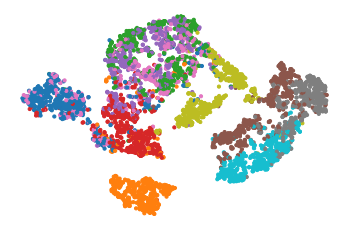

In [16]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Rendons ce diagramme un peu plus joli :

Saving figure fashion_mnist_visualization_plot


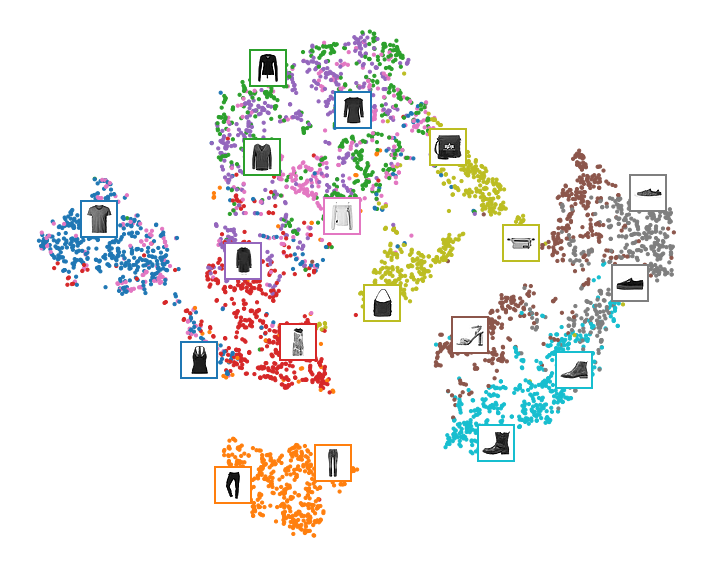

In [17]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
save_fig("fashion_mnist_visualization_plot")
plt.show()

La figure précédente montre le diagramme de dispersion obtenu (décoré de quelques
images). L’algorithme t-SNE a identifié plusieurs groupes, qui correspondent raisonnablement aux classes (chacune est représentée par une couleur différente).

Les autoencodeurs peuvent donc être employés pour la réduction de la dimensionnalité. Parmi leurs autres applications, le préentraînement non supervisé figure
en bonne place.

### Lier des poids

Lorsqu’un autoencodeur est parfaitement symétrique, comme celui que nous
venons de construire, une technique répandue consiste à lier les poids des couches
du décodeur aux poids des couches de l’encodeur. Cela permet de diviser par
deux le nombre de poids dans le modèle, accélérant ainsi l’entraînement et limitant les risques d'overfitting. Plus précisément, si l’autoencodeur comporte
**`N`** couches (sans compter la couche d’entrée) et si **W<sub>L</sub>** représente les poids des
connexions de la **L<sup>ème</sup>** couche (par exemple, la couche **1** est la première couche
cachée, la couche **N/2** est la couche de codage, et la couche **N** est la couche de
sortie), alors les poids de la couche du décodeur peuvent être simplement définis
par **W<sub>N-L+1</sub>= W<sub>L</sub><sup>T</sup>** (avec L = 1, 2, …, N/2).

Pour lier des poids entre des couches à l’aide de Keras, nous définissons une couche
personnalisée :

In [18]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

Cette couche personnalisée opère à la manière d’une couche `Dense` normale, mais elle utilise les poids d’une autre couche `Dense`, transposés (préciser `transpose_b=True` équivaut à transposer le second argument). Cependant, elle utilise son propre vecteur de termes constants.

2. En utilisant cette couche personnalisée, construisez un autoencodeur empilé, semblable au précédent, mais dont les couches Dense du décodeur sont liées aux couches Dense de l’encodeur:

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
                                             ,
            ,
    
])

tied_decoder = keras.models.Sequential([
                                                  ,
                                                  ,
    
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

tied_ae.compile(loss=                    ,
                optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(           ,          , epochs=10,
                      validation_data=(         ,          ))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3083 - val_rounded_accuracy: 0.9074
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2950 - val_rounded_accuracy: 0.9285
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3016 - val_rounded_accuracy: 0.9089
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2889 - rounded_accuracy: 0.9302 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2874 - val_rounded_accuracy: 0.9315
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [==================

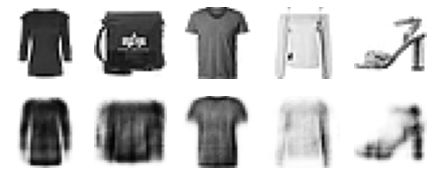

In [20]:
show_reconstructions(tied_ae)
plt.show()

Ce modèle permet d’obtenir une erreur de reconstruction légèrement plus faible
que le modèle précédent, avec un nombre de paramètres presque divisé par deux.

### Entraîner un autoencodeur à la fois

Au lieu d’entraîner l’intégralité de l’autoencodeur empilé en un seul coup, comme nous
venons de le faire, il est souvent plus rapide d’entraîner un autoencodeur peu profond à la fois, puis de les empiler tous de façon à obtenir un seul autoencodeur empilé
(d’où le nom); voir la figure suivante. Cette technique est peu employée aujourd’hui, mais
vous risquez de la rencontrer dans des articles qui parlent d’«entraînement glouton par
couche» (*greedy layer-wise training*). Il est donc intéressant de savoir ce que cela signifie.

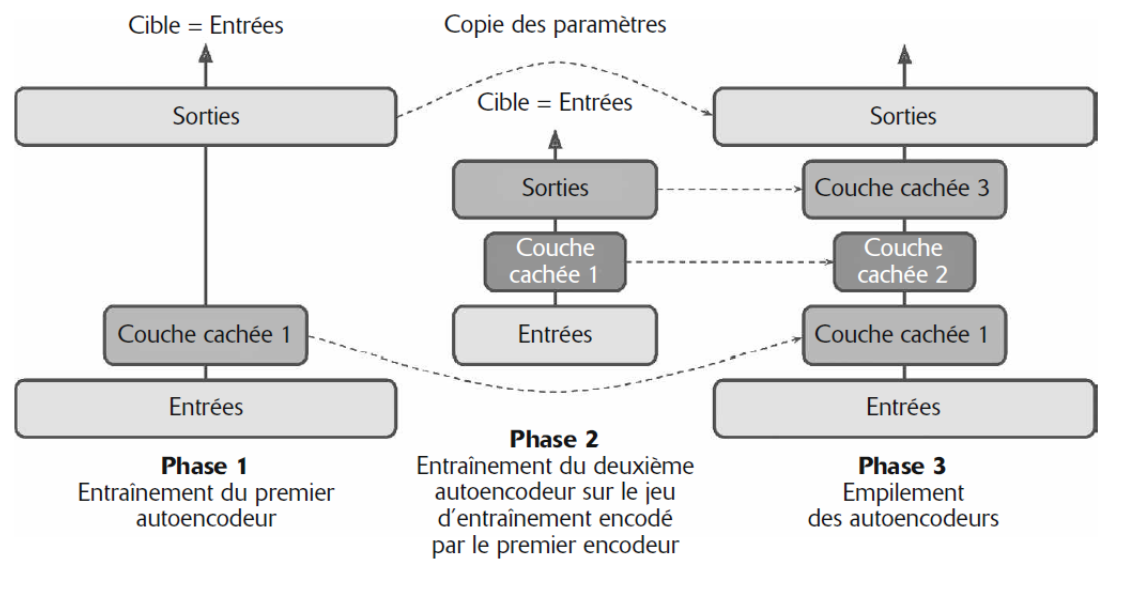

In [21]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

Au cours de la phase  1 de l’entraînement, le premier autoencodeur apprend à
reconstruire les entrées. Puis nous encodons l’intégralité du jeu d’entraînement en
utilisant ce premier autoencodeur, ce qui nous donne un nouveau jeu d’entraînement
(compressé). Ensuite, au cours de la phase 2, nous entraînons un deuxième autoencodeur sur ce nouveau jeu de données. Pour finir, nous construisons un gros sandwich avec tous ces autoencodeurs, en commençant par empiler
les couches cachées de chaque autoencodeur, puis les couches de sortie en ordre
inverse. Nous obtenons alors l’autoencodeur empilé final.

3. En utilisant la fonction `train_autoencoder` complétez le code suivant qui permet de réaliser ce processus :

In [22]:
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
X_train_flat = K.batch_flatten(X_train) # equivalent to .reshape(-1, 28 * 28)
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
        ,             ,               ,                   ,
                                ,                     ,
                        )
enc2, dec2, _, _ = train_autoencoder(
        ,           ,           ,      ,                            ,
                     )

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3445 - rounded_accuracy: 0.8874 - val_loss: 0.3123 - val_rounded_accuracy: 0.9146
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3006 - val_rounded_accuracy: 0.9246
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2949 - rounded_accuracy: 0.9286 - val_loss: 0.2934 - val_rounded_accuracy: 0.9317
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2891 - rounded_accuracy: 0.9342 - val_loss: 0.2888 - val_rounded_accuracy: 0.9363
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2853 - rounded_accuracy: 0.9378 - val_loss: 0.2857 - val_rounded_accuracy: 0.9392
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2827 - rounded_accuracy: 0.9403 - val_loss: 0.2834 - val_rounded_accuracy: 0.9409
Epoch 7/10
1719/1719 [==================

In [23]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

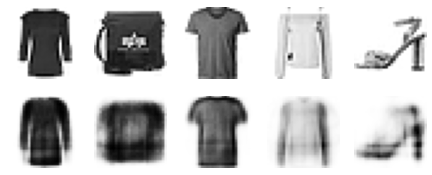

In [24]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [25]:
stacked_ae_1_by_1.compile(loss="binary_crossentropy",
                          optimizer=keras.optimizers.SGD(learning_rate=0.1), metrics=[rounded_accuracy])
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10,
                                validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2867 - rounded_accuracy: 0.9343 - val_loss: 0.2883 - val_rounded_accuracy: 0.9341
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2863 - rounded_accuracy: 0.9347 - val_loss: 0.2881 - val_rounded_accuracy: 0.9347
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2861 - rounded_accuracy: 0.9349 - val_loss: 0.2879 - val_rounded_accuracy: 0.9347
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2859 - rounded_accuracy: 0.9351 - val_loss: 0.2877 - val_rounded_accuracy: 0.9350
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2858 - rounded_accuracy: 0.9353 - val_loss: 0.2876 - val_rounded_accuracy: 0.9351
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2857 - rounded_accuracy: 0.9354 - val_loss: 0.2874 - val_rounded_accuracy: 0.9350
Epoch 7/10
1719/1719 [==================

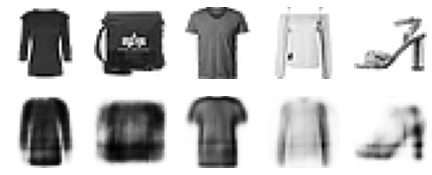

In [26]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## AUTOENCODEURS CONVOLUTIFS

Si vous manipulez des images, les autoencodeurs décrits jusqu’à présent ne fonctionneront pas très bien (sauf si les images sont très petites). Si vous souhaitez construire un autoencodeur pour des
images (par exemple, pour un préentraînement non supervisé ou une réduction de
dimensionnalité), vous devez construire un autoencodeur convolutif. L’encodeur
est un CNN normal constitué de couches de convolution et de couches de pooling.
Il réduit la dimensionnalité spatiale des entrées (c’est-à-dire la hauteur et la largeur),
tout en augmentant la profondeur (c’est-à-dire le nombre de cartes de caractéristiques). Le décodeur doit réaliser l’inverse (augmenter la taille de l’image et réduire
sa profondeur aux dimensions d’origine) et, pour cela, vous pouvez employer des
**couches de convolution transposée**.

4. Complétez le code suivant qui construit un Autoencoder convolutif empilé :

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
                                                                                                   ,
                                                                                                   ,
                                                                                                   ,
     
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 23s 9ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2844 - val_rounded_accuracy: 0.9296
Epoch 2/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9455
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2708 - rounded_accuracy: 0.9462 - val_loss: 0.2697 - val_rounded_accuracy: 0.9495
Epoch 4/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2682 - rounded_accuracy: 0.9489 - val_loss: 0.2686 - val_rounded_accuracy: 0.9491
Epoch 5/5
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2671 - val_rounded_accuracy: 0.9510


In [ ]:
conv_encoder.summary()
conv_decoder.summary()

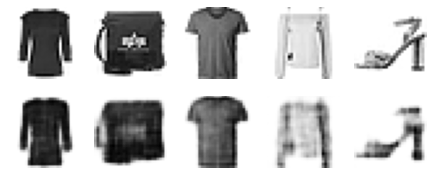

In [29]:
show_reconstructions(conv_ae)
plt.show()

## AUTOENCODEURS RÉCURRENTS

Si vous devez construire un autoencodeur pour des séquences, comme des séries
chronologiques ou du texte (par exemple, pour un entraînement non supervisé ou
une réduction de dimensionnalité), alors les réseaux de neurones récurrents peuvent être mieux adaptés que les réseaux denses. La construction d’un
autoencodeur récurrent est simple. L’encodeur est généralement un RNN série-vers-vecteur (sequence-to-vector) qui compresse la séquence d’entrée en un seul vecteur. Le décodeur est un RNN vecteur-vers-série (vector-to-sequence) qui effectue l’opération inverse :

In [30]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])

Cet autoencodeur récurrent est capable de traiter des séries de n’importe quelle
longueur, avec 28 dimensions par étape temporelle. Cela signifie qu’il peut s’occuper
des images Fashion MNIST en considérant chacune comme une suite de lignes: à
chaque étape temporelle, le RNN traitera une seule ligne de 28 pixels. Notez que la première couche du décodeur est une couche `RepeatVector` afin que
son vecteur d’entrée soit transmis au décodeur à chaque étape temporelle.

In [31]:
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 59s 30ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 51s 30ms/step - loss: 0.4050 - rounded_accuracy: 0.8432 - val_loss: 0.3741 - val_rounded_accuracy: 0.8681
Epoch 3/10
1719/1719 [==============================] - 51s 30ms/step - loss: 0.3653 - rounded_accuracy: 0.8711 - val_loss: 0.3602 - val_rounded_accuracy: 0.8766
Epoch 4/10
1719/1719 [==============================] - 51s 29ms/step - loss: 0.3507 - rounded_accuracy: 0.8809 - val_loss: 0.3524 - val_rounded_accuracy: 0.8772
Epoch 5/10
1719/1719 [==============================] - 51s 30ms/step - loss: 0.3405 - rounded_accuracy: 0.8875 - val_loss: 0.3360 - val_rounded_accuracy: 0.8918
Epoch 6/10
1719/1719 [==============================] - 51s 30ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3308 - val_rounded_accuracy: 0.8966
Epoch 7/10
1719/1719 [======

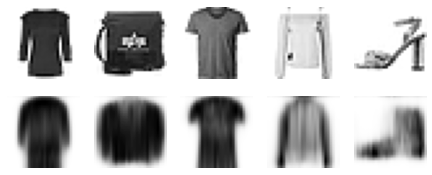

In [32]:
show_reconstructions(recurrent_ae)
plt.show()

Jusqu’à présent, pour forcer l’autoencodeur à apprendre des caractéristiques intéressantes, nous avons limité la taille de la couche de codage, le rendant ***sous-complet***.
Mais il est possible d’utiliser de nombreuses autres sortes de contraintes, y compris autoriser la couche de codage à être aussi vaste que les entrées, voire plus vaste, donnant un autoencodeur ***sur-complet***. Voyons certaines de ces approches.

## AUTOENCODEURS DÉBRUITEURS

Pour obliger l’autoencodeur à apprendre des caractéristiques utiles, une autre approche
consiste à rajouter du bruit sur ses entrées et à l’entraîner pour qu’il retrouve les
entrées d’origine, sans le bruit. Le bruit peut être un **bruit blanc gaussien** ajouté aux entrées ou un **blocage aléatoire des entrées**, comme dans la technique du **dropout**. La
figure suivante illustre ces deux possibilités :

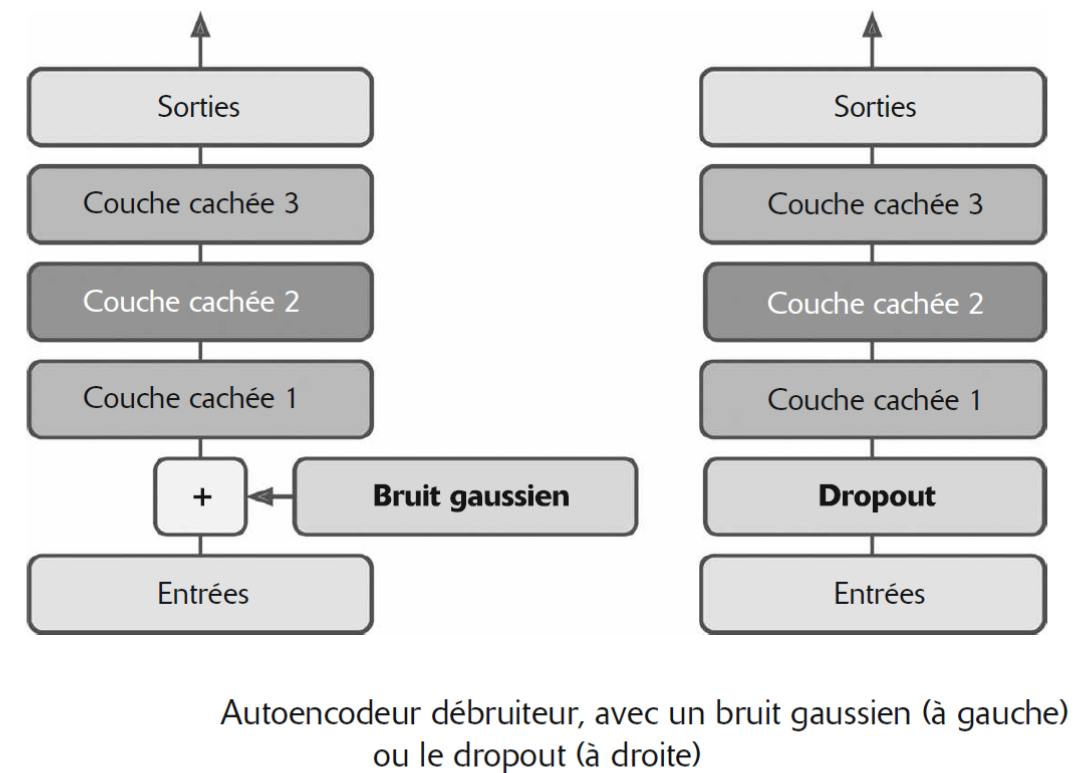

5. Complétez le code suivant qui implémente un autoencodeur débruiteur en ajoutant un bruit gauusien ( 	$\sigma$=0.2) aux entrées :

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
                                     ,
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(     , activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3500 - rounded_accuracy: 0.8773 - val_loss: 0.3166 - val_rounded_accuracy: 0.9078
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3120 - rounded_accuracy: 0.9097 - val_loss: 0.3089 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3060 - rounded_accuracy: 0.9148 - val_loss: 0.3033 - val_rounded_accuracy: 0.9179
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3025 - rounded_accuracy: 0.9179 - val_loss: 0.2999 - val_rounded_accuracy: 0.9218
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2996 - rounded_accuracy: 0.9205 - val_loss: 0.2973 - val_rounded_accuracy: 0.9237
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2974 - rounded_accuracy: 0.9223 - val_loss: 0.2959 - val_rounded_accuracy: 0.9267
Epoch 7/10
1719/1719 [=================

6. En utilisant la fonction `show_reconstructions` montrez quelques images avec du bruit gaussien et les images reconstruites par l’autoencodeur débruiteur.Rappelons que le bruit gaussien est ajouté uniquement pendant l’entraînement :

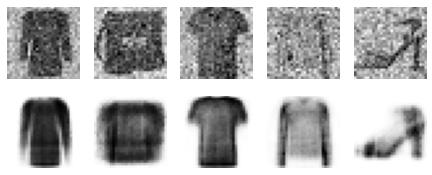

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

noise =
show_reconstructions(denoising_ae,                      )
plt.show()

7.  Complétez le code suivant qui implémente un autoencodeur débruiteur en effectuant un Dropout de 50 % appliquée aux entrées de l’encodeur :

In [35]:
tf.random.set_seed(42)
np.random.seed(42)

dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
                              ,
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(     , activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

8. En utilisant la fonction `show_reconstructions` montrez quelques images avec du bruit et les images reconstruites par l’autoencodeur débruiteur.Rappelons que la couche Dropout est active uniquement pendant l’entraînement :

Saving figure dropout_denoising_plot


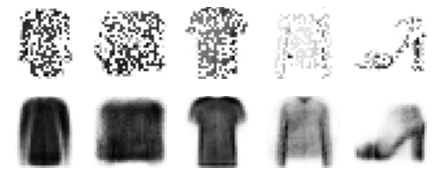

In [36]:
tf.random.set_seed(42)
np.random.seed(42)

dropout = 
show_reconstructions(dropout_ae,                         )
save_fig("dropout_denoising_plot", tight_layout=False)

## AUTOENCODEURS ÉPARS (Sparse Autoencoder)

La **dispersion** est un autre type de contrainte qui conduit souvent à une bonne
extraction de caractéristiques. En ajoutant le terme approprié à la fonction de coût,
l’autoencodeur est poussé à réduire le nombre de neurones actifs dans la couche
de codage. Par exemple, il peut être incité à n’avoir en moyenne que 5 % de neurones hautement actifs. Il est ainsi obligé de représenter chaque entrée comme une
combinaison d’un petit nombre d’activations. En conséquence, chaque neurone de
la couche de codage finit généralement par représenter une caractéristique utile (si
l’on ne pouvait prononcer que quelques mots chaque mois, on ne choisirait que les
plus importants).


Commençons par construire un autoencodeur simple empilé, afin que nous puissions le comparer aux **autoencodeurs épars** que nous allons construire. Cette fois, nous utiliserons la fonction d'activation sigmoïde pour la couche de codage, pour s'assurer que les valeurs de codage vont de 0 à 1 :

In [37]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8992
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3213 - rounded_accuracy: 0.9012 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

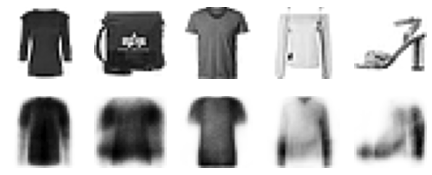

In [38]:
show_reconstructions(simple_ae)
plt.show()

Créons quelques fonctions pour imprimer les histogrammes d'activation :

In [39]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

In [40]:
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

Utilisons ces fonctions pour tracer des histogrammes des activations de la couche d'encodage :

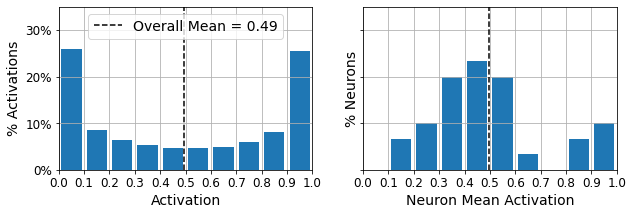

In [41]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

 L'histogramme de gauche montre la répartition de toutes les activations. On constate que les valeurs proches de 0 ou 1 sont globalement plus fréquentes, ce qui est cohérent avec le caractère saturant de la fonction sigmoïde. L'histogramme de droite montre la distribution des activations moyennes des neurones : vous pouvez voir que la plupart des neurones ont une activation moyenne proche de 0,5. Les deux histogrammes nous indiquent que chaque neurone a tendance à se déclencher près de 0 ou de 1, avec une probabilité d'environ 50 % chacun. Cependant, certains neurones se déclenchent presque tout le temps (côté droit de l'histogramme de droite).

9. Ajouter une régularisation $\ell_1$  aux activations de la couche de codage du modèle précédent :

In [42]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
     
                                                  
                                                
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [================

Cette couche de régularisation se contente de retourner ses
entrées, mais elle ajoute une perte d’entraînement égale à la somme des valeurs
absolues de ses entrées (elle n’agit que pendant l’entraînement). Cette pénalité encouragera le réseau de neurones à produire des
codages proches de 0, mais, puisqu’il sera également pénalisé s’il ne parvient pas à
reconstruire correctement les entrées, il devra sortir au moins quelques valeurs différentes de zéro. En utilisant la norme $\ell_1$
 plutôt que la norme $\ell_2$
, nous incitons le réseau
de neurones à préserver les codages les plus importants tout en éliminant ceux qui
ne sont pas indispensables pour l’image d’entrée (plutôt que de réduire simplement
tous les codages).

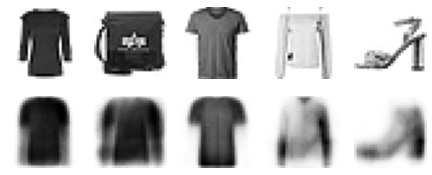

In [43]:
show_reconstructions(sparse_l1_ae)

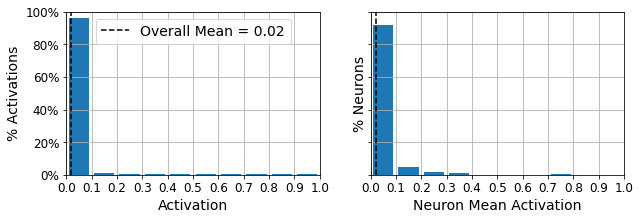

In [44]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

Let's use the KL Divergence loss instead to ensure sparsity, and target 10% sparsity rather than 0%:

Une autre approche, qui conduit souvent à de meilleurs résultats, consiste à
mesurer la dispersion actuelle de la couche de codage lors de chaque itération d’entraînement et à pénaliser le modèle lorsque la dispersion mesurée diffère d’une dispersion cible. Pour cela, on calcule l’activation moyenne de chaque neurone de la
couche de codage, sur l’intégralité du lot d’entraînement. La taille du lot ne doit pas
être trop faible pour que la moyenne puisse être suffisamment précise.

Après avoir obtenu l’activation moyenne par neurone, on pénalise ceux qui sont
trop actifs, ou pas assez, en ajoutant à la fonction de coût une **perte de dispersion** (**sparsity loss**). Par exemple, si l’on détermine que l’activation moyenne d’un neurone est
de 0,3 alors que la dispersion cible est de 0,1, il faut le pénaliser pour réduire son degré
d’activité. Une solution serait d’ajouter simplement l’erreur quadratique (0,3 – 0,1)<sup>2</sup>
à la fonction de coût, mais, en pratique, une meilleure approche consiste à utiliser
**la divergence de Kullback-Leibler**. En effet, elle
a des gradients beaucoup plus forts que l’erreur quadratique moyenne, comme le
montre la figure suivante :

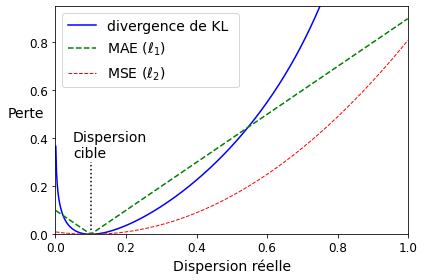

Dans notre cas, nous voulons mesurer la divergence entre la probabilité cible **p**
qu’un neurone de la couche de codage s’activera et la probabilité réelle **q** (c’est-à-dire
l’activation moyenne sur le lot d’entraînement).Divergence de KL entre la dispersion cible **p** et la dispersion réelle **q** peut être calculée à l’aide de l’équation suivante :

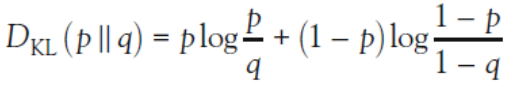

Après avoir calculé la perte de dispersion pour chaque neurone de la couche de
codage, il suffit d’additionner ces pertes et d’ajouter le résultat à la fonction de coût.
Pour contrôler l’importance relative de la perte de dispersion et de la perte de reconstruction, on multiplie la première par un hyperparamètre de poids de dispersion. Si ce
poids est trop élevé, le modèle restera proche de la dispersion cible, mais il risquera de
ne pas reconstruire correctement les entrées et donc d’être inutile. À l’inverse, s’il est
trop faible, le modèle ignorera en grande partie l’objectif de dispersion et n’apprendra
aucune caractéristique intéressante.

10. Nous disposons à présent des éléments nécessaires à l’implémentation d’un
autoencodeur épars fondé sur la divergence de KL. Commençons par créer un régularisateur personnalisé de façon à appliquer une régularisation par divergence de KL:

In [45]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(        ,                  ) +
            kl_divergence(             ,                   ))

Nous pouvons maintenant construire l’autoencodeur épars, en utilisant le **`KLDivergenceRegularizer`** pour les activations de la couche de codage :

In [46]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 11s 7ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [============

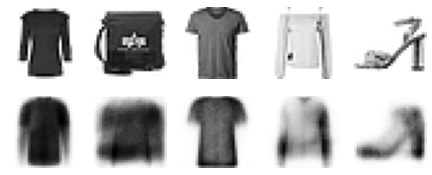

In [47]:
show_reconstructions(sparse_kl_ae)

Saving figure sparse_autoencoder_plot


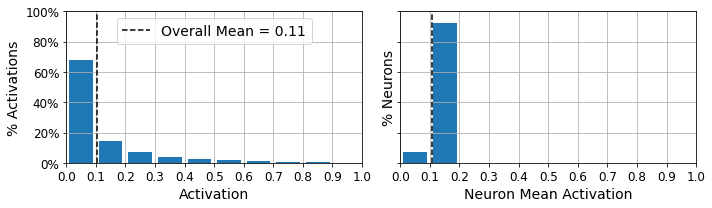

In [48]:
plot_activations_histogram(sparse_kl_encoder)
save_fig("sparse_autoencoder_plot")
plt.show()

Au terme de l’entraînement de cet autoencodeur épars sur **Fashion MNIST**, les
activations des neurones dans la couche de codage sont pour la plupart proches de 0
(environ 70 % de toutes les activations sont inférieures à 0,1) et tous les neurones ont
une activation moyenne autour de 0,1 (près de 90 % des neurones ont une activation
moyenne entre 0,1 et 0,2). La figure précédente illustre tout cela.